In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/product-reviews/Canva_reviews.xlsx


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_excel('../input/product-reviews/Canva_reviews.xlsx')
df.head()

,reviewId,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Sentiment,Sub Category,Sub Category_test
0,gp:AOqpTOFxf3fttcT5DSvFIn9KPp5FErgH9yC533Fmoxv...,Donna Caritero,https://play-lh.googleusercontent.com/a-/AOh14...,Overall it's really an amazing app. I've been ...,4,528,2.116.0,2021-06-17 07:18:54,Hi Donna. We are sorry that your text or desig...,2021-06-19 21:24:32,Negative,NaN,bug_picture_quality
1,gp:AOqpTOEq6rNIWLnPV4KFTctWvm0mpGEQljtD6mvy1H-...,Soumi Mukhopadhyay,https://play-lh.googleusercontent.com/a-/AOh14...,Hey! Yes I gave a 5 star rating... coz I belie...,5,351,2.116.0,2021-06-17 19:18:28,NaN,NaT,Positive,extremely_happy,NaN
2,gp:AOqpTOE86hSyPRHZgYt28Uk5zGe4FZGb1hkmtFDiYJ2...,Theknown _unknown,https://play-lh.googleusercontent.com/a-/AOh14...,Canva used to be a good app! But recently I've...,1,160,2.116.0,2021-06-23 19:13:28,Hi there. We're sorry to hear that you are hav...,2021-06-26 20:20:56,Negative,saving_downloading_issue,bug_saving_files
3,gp:AOqpTOHSuKkVTcM3QgCCKysHQlxEnk2ocOKsUMiMIJy...,Anthony Dean,https://play-lh.googleusercontent.com/a/AATXAJ...,"It's a brilliant app, but I have just one prob...",5,145,2.116.0,2021-06-19 23:36:07,NaN,NaT,Negative,others,bug_app_crash
4,gp:AOqpTOEOrZt5H6jXPiplJyffCd5ZBnVXACTWgwNsF1R...,Neha Diana Wesley,https://play-lh.googleusercontent.com/a-/AOh14...,This was such a great app. I used to make BTS ...,4,142,2.116.0,2021-06-21 00:29:27,Hi Neha. Sorry to hear that you are unable to ...,2021-06-24 20:46:28,Negative,others,bug_other


### Exploring Sentiment Counts, Score Counts, and Review Lengths

Text(0.5, 1.0, 'Score and Sentiment Frequencies')

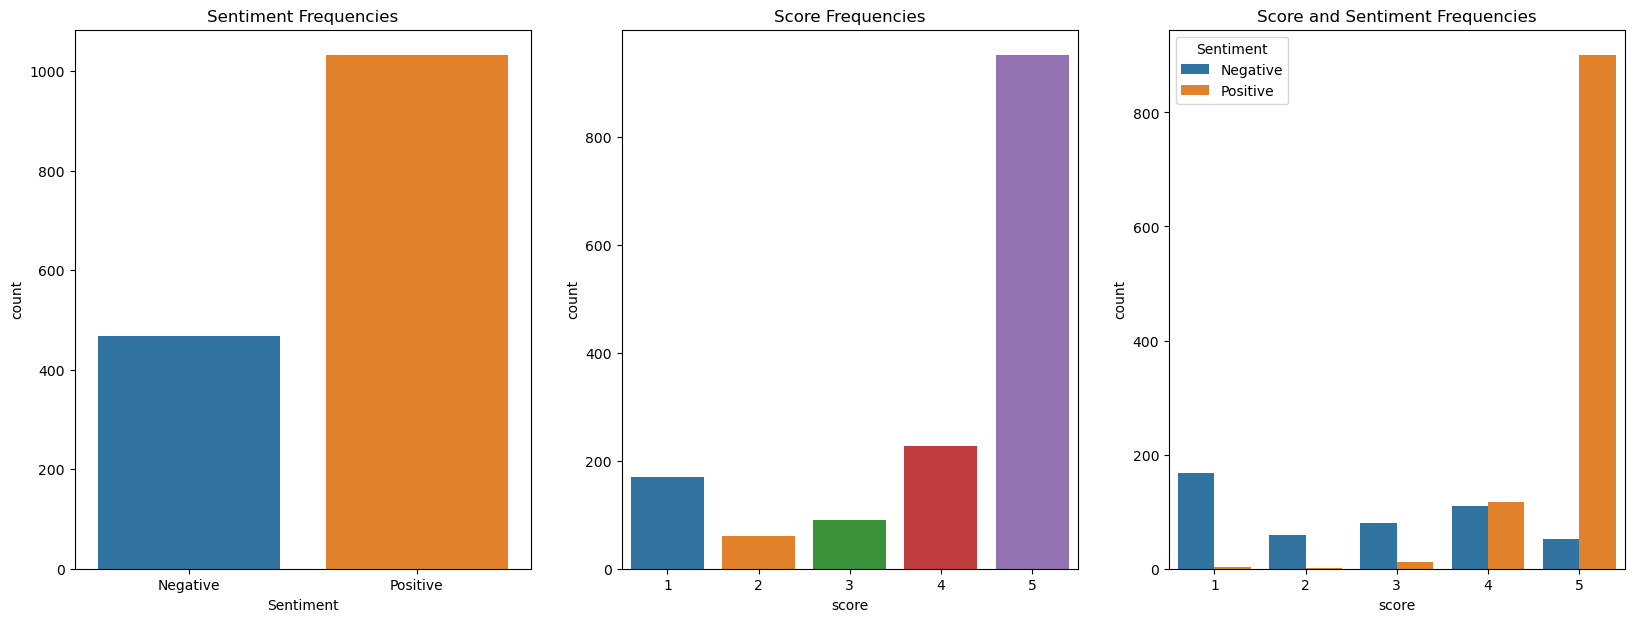

In [4]:
plt.figure(figsize=(20, 7))

plt.subplot(131)
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Frequencies')

plt.subplot(132)
sns.countplot(x='score', data=df)
plt.title('Score Frequencies')

plt.subplot(133)
sns.countplot(x='score', data=df, hue='Sentiment')
plt.title('Score and Sentiment Frequencies')

In [5]:
df['length'] = df['review'].apply(len)
df['length'].describe()

count    1500.000000
mean       86.468667
std        55.681355
min        20.000000
25%        54.000000
50%        75.000000
75%       102.000000
max       498.000000
Name: length, dtype: float64

<Axes: xlabel='length', ylabel='Count'>

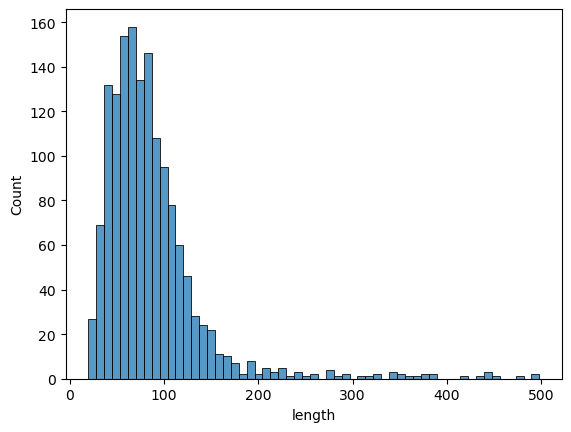

In [6]:
sns.histplot(df['length'])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution of Review Length for Different Sentiment Types')

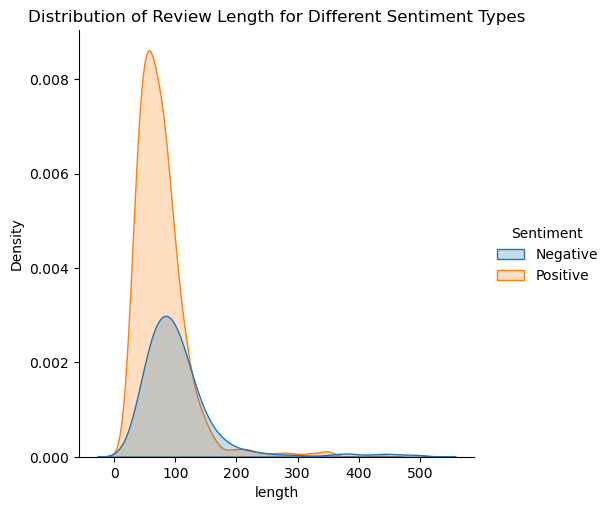

In [7]:
sns.displot(x='length', data=df, hue='Sentiment', kind='kde', fill=True)
plt.title('Distribution of Review Length for Different Sentiment Types')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution of Review Length for Different Score Types')

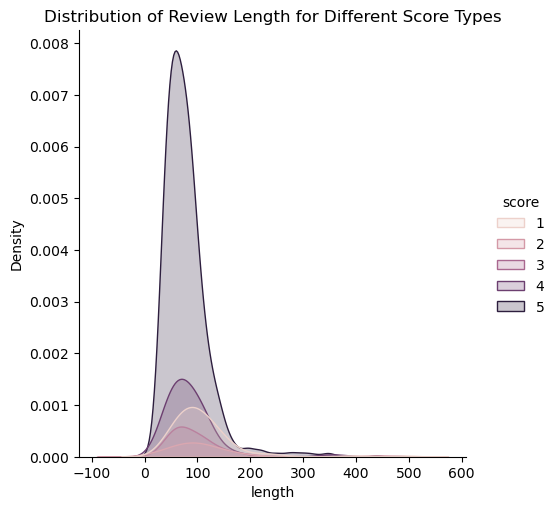

In [8]:
sns.displot(x='length', data=df, hue='score', kind='kde', fill=True)
plt.title('Distribution of Review Length for Different Score Types')

### Text Cleaning

In [9]:
# Tokenizing

reviews = list(df['review'])
reviews_lower = [r.lower() for r in reviews]
tokens = [word_tokenize(r) for r in reviews_lower]

# Removing stop words

sw = stopwords.words('english')
tokens = [[word for word in t if word not in sw] for t in tokens]

# Removing special characters

regex_tokenizer = RegexpTokenizer(r'\w+')

tokens = [["".join(regex_tokenizer.tokenize(word)) for word in t 
           if len(regex_tokenizer.tokenize(word)) > 0] for t in tokens]

# Stemming

porter = PorterStemmer()
lancaster = LancasterStemmer()

# porter.stem('teachers'), lancaster.stem('teachers'), porter.stem('absolutely'), lancaster.stem('absolutely') # porter performs better

tokens = [[porter.stem(word) for word in t] for t in tokens]
flat_tokens = [word for t in tokens for word in t] # flattening the token list

counts = Counter(flat_tokens)
print('Most frequent tokens: \n\n', counts.most_common(10))

clean_reviews = [' '.join(t) for t in tokens]
print('\n\nClean Review Count: ', len(clean_reviews))


Most frequent tokens: 

 [('app', 928), ('use', 473), ('design', 349), ('easi', 293), ('s', 240), ('love', 220), ('good', 219), ('edit', 190), ('make', 190), ('great', 184)]


Clean Review Count:  1500


### Building, Testing, Saving Model 1: Binary Count Vectorizer

In [10]:
# Vectorizing clean reviews with binary CountVectorizer

vect = CountVectorizer(binary=True, min_df=5)
X = vect.fit_transform(clean_reviews)
X.shape, len(vect.vocabulary_)

((1500, 414), 414)

In [11]:
# Visualising vector in array form and validating a test case

x_array = X.toarray()
x_array[18, :].sum(), clean_reviews[18], print(x_array)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(17,
 'nt open design even let make new one sent video screenshot canvameandroid pleas look asap ve lot project social media site client project freelanc site pend',
 None)

In [12]:
# Converting target variable to numerical type

df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)
y = df['Sentiment']

In [13]:
# Splitting vector into train-test sets, validating shapes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 414), (300, 414), (1200,), (300,))

In [14]:
model = LogisticRegression()                                                   # Instancing model
model.fit(X_train, y_train)                                                    # Fitting Model 1
y_train_pred = model.predict(X_train)                                          # Predicting with the training set
y_test_pred = model.predict(X_test)                                            # Predicting with the test set
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)     # Getting accuracy scores for train and test sets

(0.9616666666666667, 0.8833333333333333)

In [15]:
# Saving the vector and the model (Model 1: Binary Count Vectorizer)

with open("/kaggle/working/binary_count_vect.pkl", "wb") as f:
    pickle.dump(vect, f)
    
with open("/kaggle/working/binary_count_vect_lr.pkl", "wb") as f:
    pickle.dump(model, f)

### Building, Testing, Saving Model 2: Non-binary Count Vectorizer

In [16]:
# Casting text reviews as vectors with non-binary CountVectorizer and splitting vector into train and test sets

vect = CountVectorizer(min_df=5)
X = vect.fit_transform(clean_reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fitting Model 2 and getting prediction accuracy scores for train and test sets

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.9566666666666667, 0.8833333333333333)

Model 2 (non-binary) performs better than Model 1 (binary)!

In [17]:
# Saving the vector and the model (Model 2: Non-binary Count Vectorizer)

with open("/kaggle/working/count_vect.pkl", "wb") as f:
    pickle.dump(vect, f)
    
with open("/kaggle/working/count_vect_lr.pkl", "wb") as f:
    pickle.dump(model, f)

### Building, Testing, Saving Model 3: CountVectorizer with n-gram range 1-3

In [18]:
# Casting text reviews as vectors with CountVectorizer with 1-3 ngrams, and splitting vector into train and test sets

vect = CountVectorizer(min_df=5, ngram_range=(1,3))
X = vect.fit_transform(clean_reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fitting Model 3 and getting prediction accuracy scores for train and test sets

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.97, 0.8933333333333333)

Model 3 (n-grams) performs even better than Models 1 (binary) and 2 (non-binary)!

In [19]:
# Saving the vector and the model (Model 3: Count Vectorizer with 1-3 ngrams)

with open("/kaggle/working/ngram.pkl", "wb") as f:
    pickle.dump(vect, f)
    
with open("/kaggle/working/ngram_lr.pkl", "wb") as f:
    pickle.dump(model, f)

### Building, Testing, Saving Model 4: Tfidf Vectorizer

In [20]:
# Casting text reviews as vectors with TfidfVectorizer, and splitting vector into train and test sets

vect = TfidfVectorizer(min_df=5)
X = vect.fit_transform(clean_reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fitting Model 4 and getting prediction accuracy scores for train and test sets

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.935, 0.8766666666666667)

In [21]:
# Saving the vector and the model (Model 4: TfidfVectorizer)

with open("/kaggle/working/tfidf.pkl", "wb") as f:
    pickle.dump(vect, f)
    
with open("/kaggle/working/tfidf_lr.pkl", "wb") as f:
    pickle.dump(model, f)

Model 3 (n-grams) performs the best. It performs better than Models 1 (binary), 2 (non-binary) or 4 (Tfidf)!

### 2 Test Cases (Positive and Negative) with the best model (Model 3: n-grams)

In [22]:
# Selecting a positive and a negative review from main table

test1 = [df[df['Sentiment']==1].iloc[1, 3]]
test2 = [df[df['Sentiment']==0].iloc[1, 3]]

# Converting to lower-case

test1 = [r.lower() for r in test1]
test2 = [r.lower() for r in test2]

# Tokenizing words

test1 = [word_tokenize(r) for r in test1]
test2 = [word_tokenize(r) for r in test2]

# Removing stop words

test1 = [[word for word in t if t not in sw] for t in test1]
test2 = [[word for word in t if t not in sw] for t in test2]

# Removing special characters and recombining words

test1 = [[" ".join(regex_tokenizer.tokenize(word)) for word in t if len(regex_tokenizer.tokenize(word)) > 0] for t in test1]
test2 = [[" ".join(regex_tokenizer.tokenize(word)) for word in t if len(regex_tokenizer.tokenize(word)) > 0] for t in test2]

# Stemming with the better performing PorterStemmer

test1 = [[porter.stem(word) for word in t] for t in test1]
test2 = [[porter.stem(word) for word in t] for t in test2]

# Recombining words into sentences. This gives the clean text, ready for vectorization and model-fitting.

test1 = [" ".join(r) for r in test1]
test2 = [" ".join(r) for r in test2]

In [23]:
# Loading the best performing Model 3, CountVectorizer with n-gram range 1-3

vect = pickle.load(open("/kaggle/working/ngram.pkl", "rb"))
model = pickle.load(open("/kaggle/working/ngram_lr.pkl", "rb"))

In [24]:
# Casting the 2 text reviews as vectors with the best model (Model 3, CountVectorizer (ngrams: 1-3))
X_test1 = vect.transform(test1)
X_test2 = vect.transform(test2)

# Generating and validating predictions. The model performs accurately.

model.predict_proba(X_test1), model.predict(X_test1), model.predict_proba(X_test2), model.predict(X_test2)

(array([[0.01462834, 0.98537166]]),
 array([1]),
 array([[9.99954882e-01, 4.51178702e-05]]),
 array([0]))

**Consolidated Code**

df = pd.read_excel('../input/product-reviews/Canva_reviews.xlsx')

reviews = list(df['review'])  
reviews_lower = [r.lower() for r in reviews]  
tokens = [word_tokenize(r) for r in reviews_lower]  

sw = stopwords.words('english')  
tokens = [[word for word in t if word not in sw] for t in tokens]  

porter = PorterStemmer()  
lancaster = LancasterStemmer()  

porter.stem('teachers'), lancaster.stem('teachers'), porter.stem('absolutely'), lancaster.stem('absolutely')    

tokens = [[porter.stem(word) for word in t] for t in tokens]  
flat_tokens = [word for t in tokens for word in t]    

counts = Counter(flat_tokens)  

clean_reviews = [' '.join(t) for t in tokens]

vect = CountVectorizer(binary=True, min_df=5)     
*change vectorizers to get different models*  

X = vect.fit_transform(clean_reviews)  
X.shape, len(vect.vocabulary_), type(x)    


df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)  

X_train.shape, X_test.shape, y_train.shape, y_test.shape  


model = LogisticRegression()  
model.fit(X_train, y_train)  
y_pred = model.predict(X_test)  
accuracy_score(y_test, y_pred)  